In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop
from keras.layers import BatchNormalization

from tqdm import tqdm


Using TensorFlow backend.


In [2]:
SEED = 7
np.random.seed(SEED) 
set_random_seed(SEED)

# take in data
df_train = pd.read_csv("../aptos2019/train.csv") 
df_test  = pd.read_csv("../aptos2019/test.csv")


# point data to file types
df_train.id_code = df_train.id_code.apply(lambda x: x+".png")
df_test.id_code  = df_test.id_code.apply(lambda x: x+".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')


In [3]:
IMG_DIM      = 256
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
NUM_EPOCHS   = 12
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_CLASSES = df_train['diagnosis'].nunique()

class_names = {"0":"No DR", "1":"Mild", "2":"Moderate", "3":"Severe", "4":"Proliferative DR"}

df_train.columns, df_test.columns, NUM_CLASSES


(Index(['id_code', 'diagnosis'], dtype='object'),
 Index(['id_code'], dtype='object'),
 5)

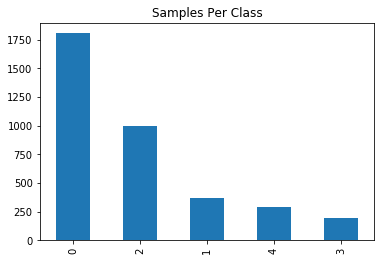

In [4]:
df_train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');


In [5]:
def squareUp(y, ycc):
    
    thresh = 5
    
    # remove any black regions, where black is y under the threshold
    rowMaxes = y.max(axis=1)
    top = 0
    while rowMaxes[top] < thresh:
        top += 1
    bottom = len(rowMaxes) - 1
    while rowMaxes[bottom] < thresh:
        bottom -= 1
        
    middleRow = y[int((bottom-top)/2)]
    left = 0
    while middleRow[left] < thresh:
        left += 1
    right = len(middleRow) - 1
    while middleRow[right] < thresh:
        right -= 1
        
    height = bottom - top
    width  = right - left
        
    if height < 100 or width < 100:
        print("Error: squareUp: bottom:", bottom, "top:", top)
        print("Error: squareUp: right:", right, "left:", left)
        return ycc
    
    # Make a blank canvas, of the size of a square of the larger of the above
    length = max(height, width)
    blank_image = np.full((length, length, 3), 128, np.uint8)
    blank_image[:,:,0] = 0 # black in ycc is 0 128 128
    
    ycc = ycc[top:bottom, left:right]
    v_offset  = int((length - height)/2)
    h_offset = int((length - width)/2)
    blank_image[v_offset:v_offset+height, h_offset:h_offset+width] = ycc
    
    return blank_image
    

# assumes RGB
def colourfulEyes(img):
        
    # convert to y, cr, cb so that we can modify the image based on just the y (brightness)
    ycc = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycc)

    # perform bens algorithm on the y component
    y = cv2.addWeighted(y, 3, cv2.GaussianBlur(y, (0,0), 60),-3, 128)

    # merge the ycc back together, and recolor it
    ycc_modified = cv2.merge((y, cr, cb))
    rgb_modified = cv2.cvtColor(ycc_modified, cv2.COLOR_YCrCb2RGB)
    
    return rgb_modified 

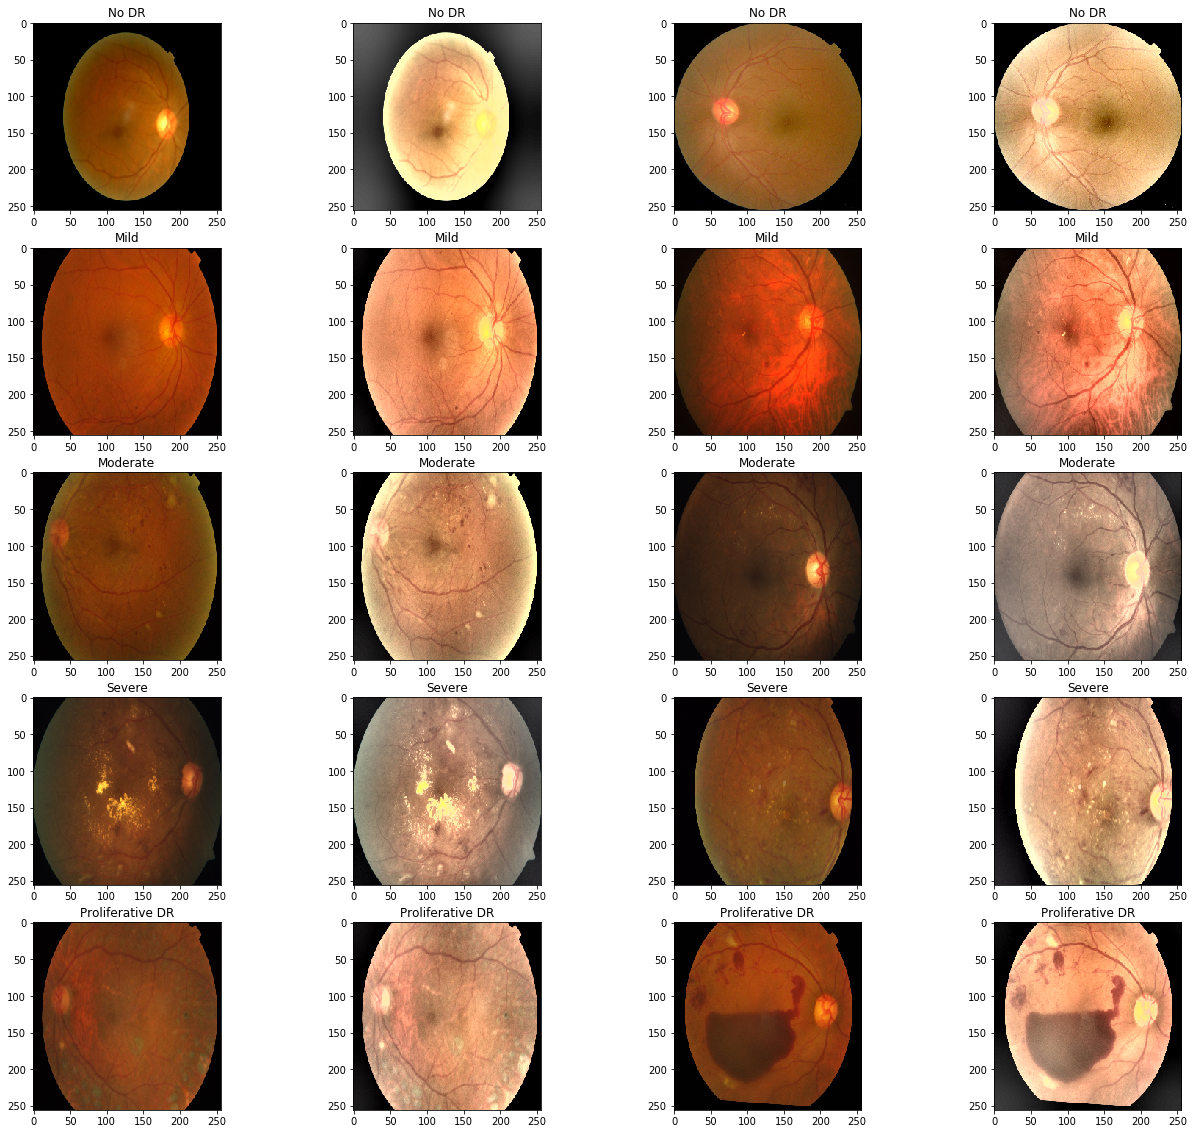

In [6]:
# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(22,20))
for target_class in (df_train['diagnosis'].unique()):
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis == target_class]
                                    .sample(2)
                                    .iterrows()):
        # open the file
        imagefile = f"../aptos2019/train_images/{row['id_code']}" 
        img = cv2.imread(imagefile)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        
        # original version
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
        plt.imshow(rgb)
        ax.set_title(class_names[target_class])
        
        # colored version
        funky = colourfulEyes(rgb)
        ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
        plt.imshow(funky)
        ax.set_title(class_names[target_class])
        

In [8]:
# taken from https://jkjung-avt.github.io/keras-image-cropping/
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1] 
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1) 
    img=img[y:(y+dy), x:(x+dx), :] 
    return img
    
# Take as input a Keras ImageGen (Iterator) and generate random
# crops from the image batches generated by the original iterator.
def crop_generator(batches, crop_length):    
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[0] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

            
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training
SIZE_PRE_CROP = 2 * IMG_DIM

datagen = image.ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   preprocessing_function=colourfulEyes
                                  )

train_generator = datagen.flow_from_dataframe(dataframe=df_train,
                                              directory="../aptos2019/train_images/",
                                              x_col="id_code",
                                              y_col="diagnosis",
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              target_size=(SIZE_PRE_CROP, SIZE_PRE_CROP),
                                              subset='training', 
                                              interpolation="bilinear",
                                              seed=SEED,
                                             )

valid_generator = datagen.flow_from_dataframe(dataframe=df_train,
                                              directory="../aptos2019/train_images/",
                                              x_col="id_code",
                                              y_col="diagnosis",
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              target_size=(SIZE_PRE_CROP, SIZE_PRE_CROP),
                                              subset='validation',
                                              interpolation="bilinear",
                                              seed=SEED
                                             )

# make cropped versions of the generated data
cropped_train_gen = crop_generator(train_generator, IMG_DIM)
cropped_valid_gen = crop_generator(valid_generator, IMG_DIM)

gc.collect()


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


2447

In [9]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', 
                               min_delta=0.0004, 
                               patience=2, 
                               factor=0.1, 
                               min_lr=1e-6,  
                               mode='auto', 
                               verbose=1
                              )

NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUM_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUM_TRAIN_STEPS, NUM_VALID_STEPS


(91, 22)

In [10]:
def create_resnet(img_dim, CHANNELS, n_class):
    input_tensor=Input(shape=(img_dim, img_dim, CHANNELS))
  
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('../resnet50/base.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation=relu)(x)
    x = Dropout(0.15)(x)
    x = Dense(512, activation=relu)(x)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)
    
    return model_resnet

model_resnet=create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)


W0810 11:06:21.393753 140673193932544 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0810 11:06:21.394668 140673193932544 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0810 11:06:21.400242 140673193932544 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0810 11:06:21.424698 140673193932544 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py

In [11]:
# todo: don't think this is thinking of frozen layers
for layers in model_resnet.layers:
    layers.trainable = True

lr = 1e-3
optimizer = rmsprop(lr=lr, decay=0.1)
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])
# model_resnet.summary()
gc.collect()

W0810 11:06:31.411038 140673193932544 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



365

In [ ]:
# train the model for 12 epochs
history = model_resnet.fit_generator(generator=cropped_train_gen,
                                      steps_per_epoch=NUM_TRAIN_STEPS,
                                      validation_data=cropped_valid_gen,
                                      validation_steps=NUM_VALID_STEPS,
                                      epochs=NUM_EPOCHS,
                                      callbacks=[early_stop, reduce_lr],
                                      verbose=1
                                     )
gc.collect()

W0810 11:06:31.727319 140673193932544 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/12
29/91 [========>.....................] - ETA: 11:22 - loss: 1.5796 - acc: 0.4030

In [ ]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy)=tqdm(model_resnet.evaluate_generator(generator=valid_generator,steps=NUB_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 


# as it was, with the eye colouring
# [INFO] accuracy: 84.71%
# [INFO] Loss: 0.45822140898023334

In [ ]:
test_datagen = image.ImageDataGenerator(rescale=1./255,
                                        horizontal_flip=True
                                       )

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory = "../aptos2019/test_images/",
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False, 
                                                  class_mode=None, 
                                                  interpolation="bilinear",
                                                  seed=SEED
                                                 )
# del df_test
print(df_test.shape[0])
gc.collect()

In [ ]:
tta_steps = 10
preds_tta=[]
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model_resnet.predict_generator(generator=test_generator,steps =ceil(df_test.shape[0]))
#     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))